## House Prices: Advanced Regression Techniques

The Notebook is based on a Kaggle competition with the following description. Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### EDA: Exploratory Data Analysis

As the description suggest we probably want to have a better undestanding of the data before diving into a complex Machine Learning algorithm. We start by reading our data into a Pandas dataframe and finding the type of the variables in it.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
sample=pd.read_csv('sample_submission.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [4]:
train_copy=train.copy()
test_copy=test.copy()

In [5]:
numeric=train.select_dtypes(include=[np.number]) #selecting the data asociate with the numerical variables

In [6]:
categorical=train.select_dtypes(exclude=[np.number]) #selecting the data asociate with the categorical variables

As we can see there are 38 numerical variables including SalePrice and Id:

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
       
 Similarly there are 43 categorical variables:
 
   ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition']


### Exploring the Target variable; SalePrice

Normally most of the people can buy houses with low prices. Now let's see if this is reflected in the histogram of our target variable.

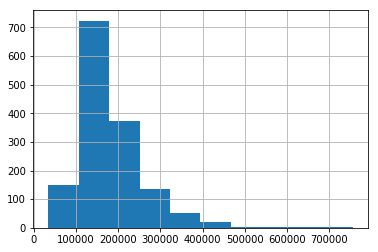

In [7]:
train['SalePrice'].hist()

### Skewness

It is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution.

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.

If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.

If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.

As it was expected our target variable is right skewed, therefore we have to normalize its distribution. There are many ways to approaching this but we have selected a simple one: logarithm transformation, but we are going to do this later.

In [8]:
y=train['SalePrice']

We also eliminate the  target variable and the Id to form the feature set.

In [9]:
train.drop(['SalePrice','Id'], axis=1, inplace=True)

In [10]:
numeric.drop(['SalePrice','Id'], axis=1, inplace=True)
num_columns=numeric.columns

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


We use the skew function to find the features variables wich are skewed and select between them the ones with high values based on the criteria presented before.

In [11]:
def select_skew_index(df):
    numeric=df.select_dtypes(include=[np.number])
    num_columns=numeric.columns
    skew_features = df[num_columns].skew(axis = 0, skipna = True)
    high_skewness = skew_features[skew_features > 0.5]
    skew_index = high_skewness.index
    return skew_index

In [12]:
skew_index=select_skew_index(train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1209954a8>,
      dtype=object)

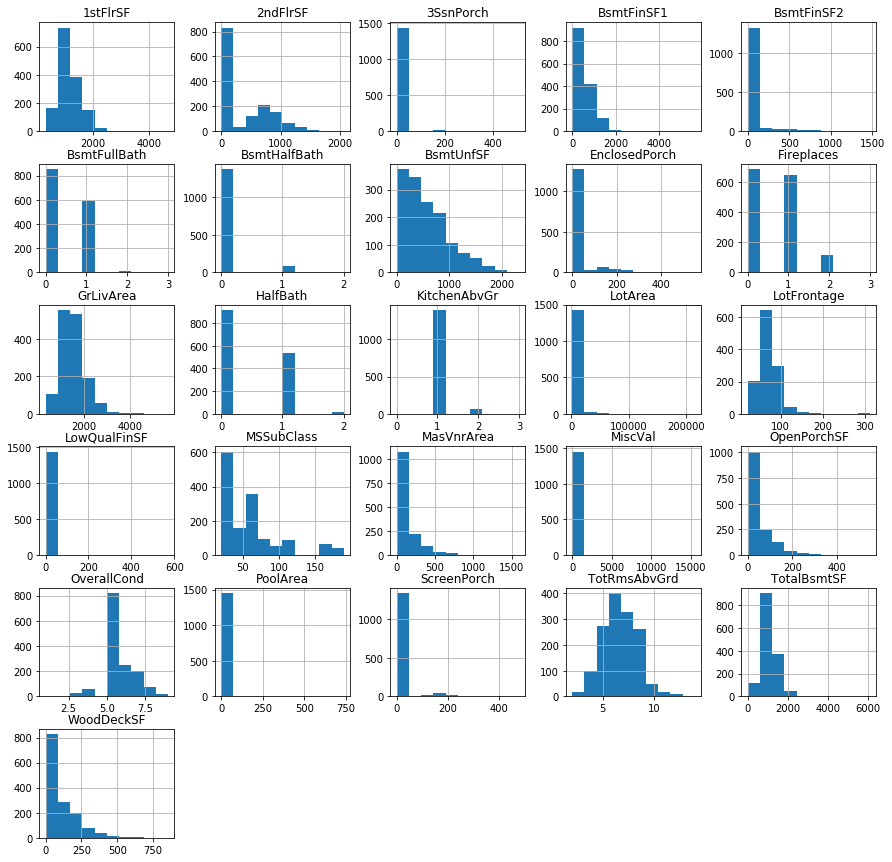

In [13]:
train[skew_index].hist(figsize=(15,15))

#### Kurtosis
It describe the extreme values in one versus the other tail and measures the outliers present in the distribution.

High kurtosis in a data set is an indicator that data has heavy tails or outliers. In this case we should investigate wrong data entry or other things.


In [14]:
kurt_features = train[num_columns].kurtosis(axis = 0, skipna = True)

In [15]:
high_kurt = kurt_features[kurt_features > 3]
kurt_index = high_kurt.index
high_kurt

LotFrontage       17.452867
LotArea          203.243271
MasVnrArea        10.082417
BsmtFinSF1        11.118236
BsmtFinSF2        20.113338
TotalBsmtSF       13.250483
1stFlrSF           5.745841
LowQualFinSF      83.234817
GrLivArea          4.895121
BsmtHalfBath      16.396642
KitchenAbvGr      21.532404
OpenPorchSF        8.490336
EnclosedPorch     10.430766
3SsnPorch        123.662379
ScreenPorch       18.439068
PoolArea         223.268499
MiscVal          701.003342
dtype: float64

#### Outliers

As we saw before it is a good approach to look for outlier in the variables with high values of kurtosis. To have a better idea let's draw the scatter plot of this variables.

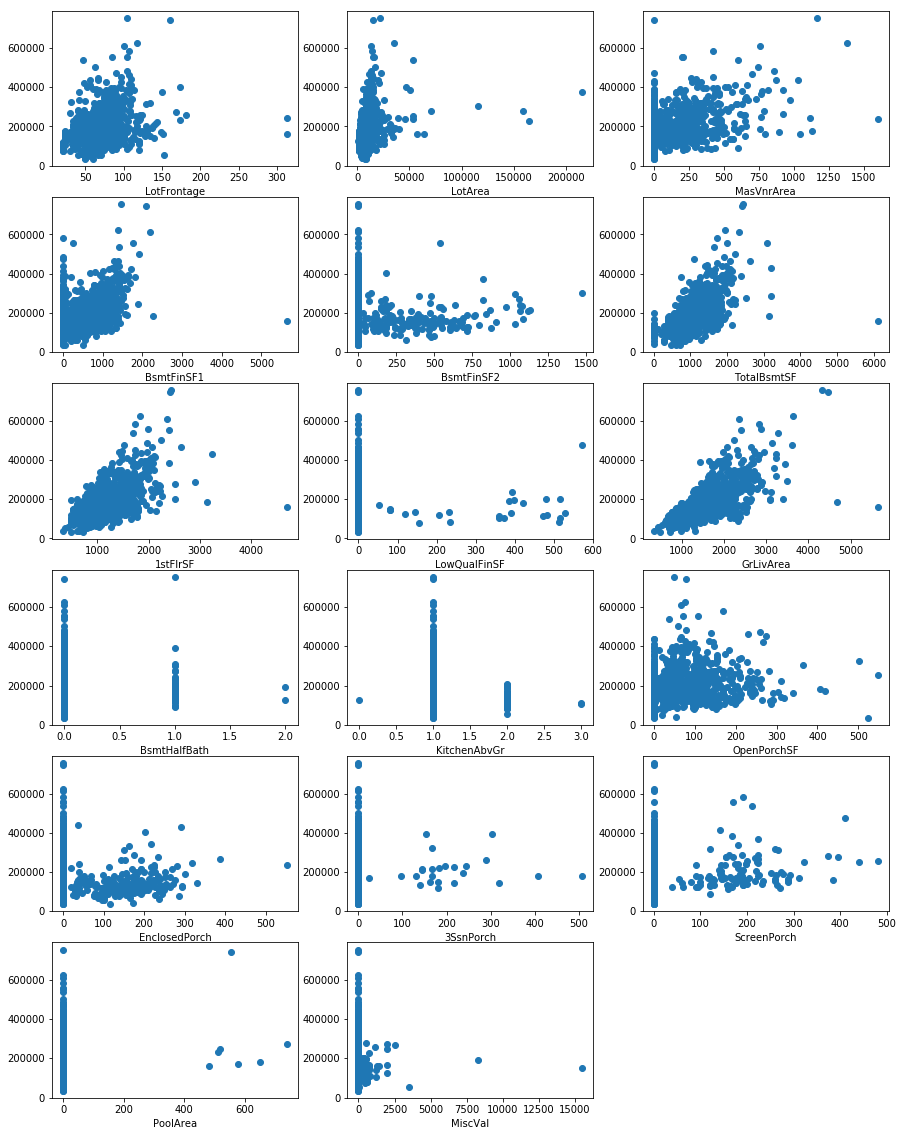

In [16]:
fig=plt.figure(figsize=(15,20))
for i in range(1,18):
    ax=fig.add_subplot(6,3,i)
    ax.scatter(x=train[kurt_index[i-1]], y=y)
    ax.set_xlabel(kurt_index[i-1])

From these graphics we can see that there is one value in 'BsmtFinSF1','GrLivArea' and 'TotalBsmtSF' each, with high values of square feets and low sale price. That has no sense, moreover, when find this value for 'BsmtFinSF1','GrLivArea' and 'TotalBsmtSF' it turns to be the same index 1298. Therefore, 1298 its our first candidate
to outlier.

In [17]:
train[train['BsmtFinSF1']>5000].index

Int64Index([1298], dtype='int64')

In [18]:
train[train['TotalBsmtSF']>6000].index

Int64Index([1298], dtype='int64')

In [19]:
train[train['GrLivArea']>5000].index


Int64Index([1298], dtype='int64')

In [20]:
train.shape

(1460, 79)

In [21]:
train=train.drop(train.index[1298])
y=y.drop(y.index[1298])

In [22]:
train.shape

(1459, 79)

Now we want to correct the skewness and kurtosis by applying a logarithm transformation. We start with our target variable and then continue with the features

In [23]:
y=np.log1p(y)

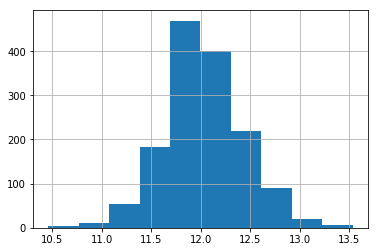

In [24]:
y.hist()

Now it looks much better. 

In [25]:
def correct_skew(df,skew_index):
    for i in skew_index:
        df[i] = np.log1p(df[i])

In [26]:
correct_skew(train,skew_index)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f10dac8>,
      dtype=object)

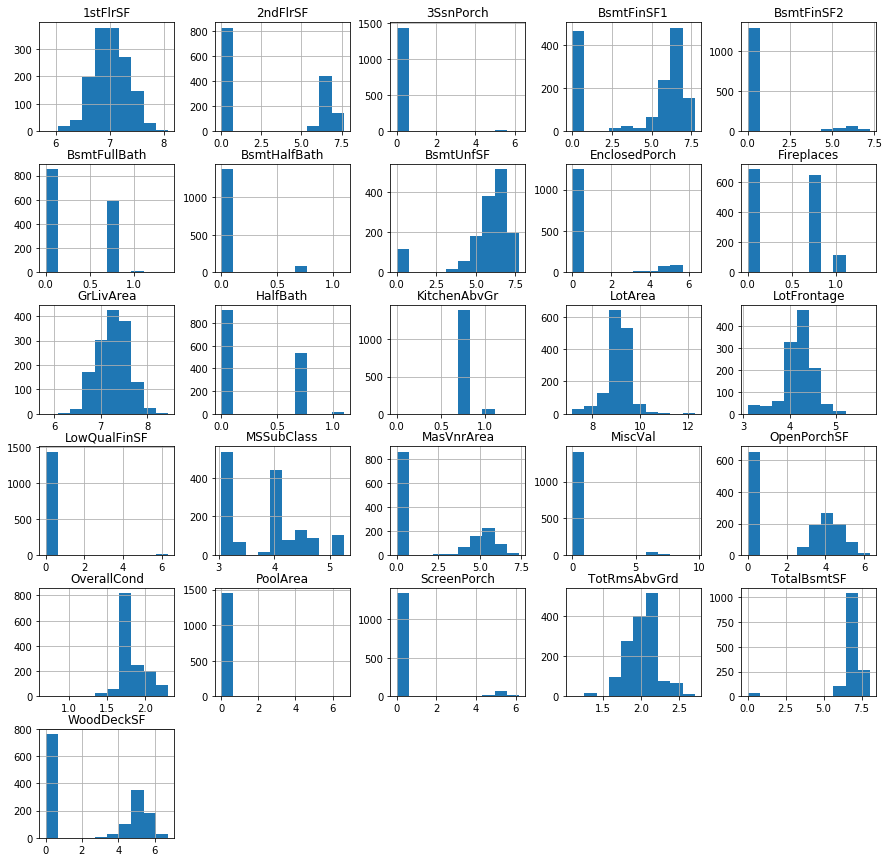

In [27]:
train[skew_index].hist(figsize=(15,15))

#### Filling missing values
We start by finding the variables with nan values

In [28]:
train.isnull().sum().sort_values(ascending=False)[0:25]

PoolQC          1453
MiscFeature     1405
Alley           1368
Fence           1178
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
LotConfig          0
LandSlope          0
MSZoning           0
Foundation         0
ExterCond          0
ExterQual          0
dtype: int64

First we have to look at the data description for a better understanding of the data. There are variables like Alley for which NA values means No alley access and variables like 'GarageCars' for which NA means 0.

In [29]:
def fill_miss(df):
    Nvalues=['FireplaceQu','GarageFinish','BsmtCond','Alley','BsmtExposure','GarageCond','PoolQC','BsmtQual',
             'MiscFeature','MasVnrType','BsmtFinType1','GarageType','Fence','GarageQual','BsmtFinType2']
    GarBsmt=['GarageYrBlt','GarageCars','GarageArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
'BsmtFullBath','BsmtHalfBath']
    df_cat=df.select_dtypes(exclude=[np.number])
    stats_df=df_cat.describe() 
    for i in df.columns:
        if(i in Nvalues):
            df[i].replace(np.nan,"None", inplace=True )
        elif(i in GarBsmt):
            df[i].replace(np.nan,0, inplace=True )
        
    for i in df_cat.columns:
        top = stats_df[i].iloc[2]
        if(df[i].isnull().sum()!=0):
            df[i].replace(np.nan,top, inplace=True )
            
    df.interpolate(inplace=True)

In [30]:
fill_miss(train)

In [31]:
train.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea    

### Categorical variables

Now we have to work with the categorical variables and select the ones that are ordinal and nominal to find a correct approach for them. For this we have to look the data description and find similarities between categories. We have notice that the variable MSSubClass is in fact categorical therefore we hace to change its type to object.

Also we want to look for variables which have the majority of its elements in only one category, for this we have the following function:

In [32]:
def uniq_cat(df):
    categoric=df.select_dtypes(exclude=[np.number])
    cat_col=categoric.columns
    high_val=[]
    for i in cat_col:
        for j in range(df[i].unique().shape[0]):
            if ((df[i].value_counts()[j])/1459 > 0.99):
                 high_val.append(i) 
    return high_val

In [33]:
uniq_cat(train)

['Street', 'Utilities', 'PoolQC']

In [34]:
train = train.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

We change the variables that are ordinal according to the importance of the category. We combine the variables Condition1 and Condition2 into dummies to avoid duplicates later

In [35]:
def filling_ordinal(df):
    feat=['ExterQual','ExterCond','BsmtQual','BsmtCond','KitchenQual','HeatingQC','KitchenQual'
          ,'HeatingQC','GarageQual','GarageCond']
    for x in feat:  
        df[x][df[x] == 'Ex'] = 5
        df[x][df[x] == 'Gd'] = 4
        df[x][df[x] == 'TA'] = 3
        df[x][df[x] == 'Fa'] = 2
        df[x][df[x] == 'Po'] = 1
        df[x][df[x] == 'None'] = 0
        
    df['LandSlope'][df['LandSlope'] == 'Sev'] = 3
    df['LandSlope'][df['LandSlope'] == 'Mod'] = 2
    df['LandSlope'][df['LandSlope'] == 'Gtl'] = 1
    
    df['BsmtExposure'][df['BsmtExposure'] == 'Gd'] = 4
    df['BsmtExposure'][df['BsmtExposure'] == 'Av'] = 3
    df['BsmtExposure'][df['BsmtExposure'] == 'Mn'] = 2
    df['BsmtExposure'][df['BsmtExposure'] == 'No'] = 1
    df['BsmtExposure'][df['BsmtExposure'] == 'None'] = 0
    
    feat1=['BsmtFinType1','BsmtFinType2']
    
    for x in feat1:
        df[x][df[x] == 'GLQ'] = 6
        df[x][df[x] == 'ALQ'] = 5
        df[x][df[x] == 'BLQ'] = 4
        df[x][df[x] == 'Rec'] = 3
        df[x][df[x] == 'LwQ'] = 2
        df[x][df[x] == 'Unf'] = 1
        df[x][df[x] == 'None'] = 0
        
    df['CentralAir'][df['CentralAir'] == 'Y'] = 1
    df['CentralAir'][df['CentralAir'] == 'N'] = 0
    

In [36]:
filling_ordinal(train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

### Feature Ingeneering

In [37]:
def feat_ing(X):
    X['TotalBath']=X['BsmtFullBath']+ (1/2)*X['BsmtHalfBath']+X['FullBath']+ (1/2)*X['HalfBath']
    X['TotalSF']=X['TotalBsmtSF']+X['1stFlrSF']+X['2ndFlrSF']

In [38]:
feat_ing(train)

In [39]:
X=pd.get_dummies(train)

In [40]:
def clean(rtrain,rtest):
    y=rtrain['SalePrice']
    testId=rtest['Id']
    rtrain.drop(['Id','SalePrice'],axis=1,inplace=True)
    rtest.drop(['Id'],axis=1,inplace=True)
    
    # selecting the indexes of the skew features
    skew_index=select_skew_index(rtrain)
    
    # Eliminate the outier
    rtrain=rtrain.drop(rtrain.index[1298])
    y=y.drop(rtrain.index[1298])
    
    # Drop the columns in the test data with all values equal to na
    rtest=rtest.dropna(axis=1,how='all')
    
    # preparing features and target values
    y=np.log1p(y)

    #Correct the skewness
    #correct_skew(rtrain,skew_index)
    #correct_skew(rtest,skew_index)
    
    #Filling missing values
    fill_miss(rtrain)
    fill_miss(rtest)
    
    #Drop the features with low information
    #rtrain = rtrain.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'PoolQC'], axis=1)
    #rtest = rtest.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'PoolQC'], axis=1)
    
    # Correcting categorical values that are ordinal
    filling_ordinal(rtrain)
    filling_ordinal(rtest)
    
    #Feature ingeneering
    feat_ing(rtrain)
    feat_ing(rtest)
    
    #One hot encoding
    rtrain=pd.get_dummies(rtrain)
    rtest=pd.get_dummies(rtest)
    
    # Update the training set
    rtrain=rtrain[rtest.columns]
    
    
    return(rtrain,rtest,y,testId)

In [41]:
X,Xtest,y,TestId=clean(train_copy,test_copy)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [54]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(X,y,test_size=0.33, random_state=77)

In [43]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
parameters= {'alpha':[0.0001,0.0002,0.0003,0.0004,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]}

lasso=Lasso()
lasso_reg=GridSearchCV(lasso, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)
lasso_reg.fit(X,y)

print('The best value of Alpha is: ',lasso_reg.best_params_,'neg_mean_squared_error',lasso_reg.best_score_)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

The best value of Alpha is:  {'alpha': 0.0009} neg_mean_squared_error -0.015100653673886506


In [44]:
from sklearn import linear_model
from sklearn.linear_model import Lasso

best_alpha=0.0009
lasso = Lasso(alpha=best_alpha,max_iter=10000)
lasso.fit(X,y)

Lasso(alpha=0.0009, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [45]:
ytest=lasso.predict(Xtest)
#ytest_ridge=ridge.predict(Xtest)
#ytest=(ytest_ridge+ytest_lasso)/2

In [46]:

ytest=np.expm1(ytest)

In [55]:
from sklearn import ensemble
# Define the model with 
gbm=ensemble.GradientBoostingRegressor(random_state=1)
gbm.fit(x_train,y_train)
from sklearn.metrics import mean_absolute_error
ypred=gbm.predict(x_test)
ypred=np.expm1(ypred)
y_test=np.expm1(y_test)
# Compute the mean absolute error in the test set
mean_absolute_error(y_test,ypred)

13776.073314521453

In [56]:
# Now let's go to tune the hyperparameters using a grid search
from sklearn.model_selection import GridSearchCV
import numpy as np
# Parameters for the grid search
parameters={'n_estimators':range(10,500,10),
           'learning_rate': np.arange(0.1,1,10)}
# Model declaration
rgm=ensemble.GradientBoostingRegressor(random_state=1)
gbm_gs=GridSearchCV(rgm,param_grid=parameters,cv=10,scoring='neg_mean_absolute_error')

grid_result=gbm_gs.fit(X,y)

print(grid_result.best_params_)

{'learning_rate': 0.1, 'n_estimators': 190}
-0.08328302080957345


In [57]:
from sklearn import ensemble
# Define the model with 
gbm=ensemble.GradientBoostingRegressor(random_state=1,learning_rate= 0.1, n_estimators= 190)
gbm.fit(X,y)
from sklearn.metrics import mean_absolute_error
ypred=gbm.predict(Xtest)
ypred=np.expm1(ypred)

In [58]:
#FI_lasso = pd.DataFrame({"Feature":X.columns, 'Importance':lasso.coef_})

In [59]:
#FI_lasso=FI_lasso.sort_values("Importance",ascending=False)

In [60]:
#import seaborn as sns
#sns.barplot(x='Importance', y='Feature', data=FI_lasso.head(10),color='b')

In [61]:
prediction=pd.DataFrame({'Id': TestId, 'SalePrice': ypred})

In [62]:
prediction

,Id,SalePrice
0,1461,119955.576189
1,1462,160803.399308
2,1463,177811.800556
3,1464,188107.137068
4,1465,186799.699793
5,1466,172619.444759
6,1467,180080.148797
7,1468,166623.553089
8,1469,188594.684984
9,1470,123343.307338


In [63]:
prediction.to_csv('submission.csv', index=False)